In [1]:
import tensorflow as tf
from model_training.model.yolov3 import Create_Yolo
from model_training.model.utils import load_yolo_weights, detect_image, detect_video
from model_training.model.configs import YOLO_INPUT_SIZE, TRAIN_CLASSES
import cv2
import matplotlib.pyplot as plt
import datetime
import os

# Model Training

Everything that has to do with the training of the model is stored or defined in the script "train.py".
To start the training simply run the script.
When you start the training for the first time make sure that:
1. Download yolov3.weights from [creators homepage](https://pjreddie.com/darknet/yolo/)
2. Save weights file to "./model_training/model_data/"
3. class_names.txt, class_test.txt and class_train.txt is present in "./model_training/model_data/"
4. "./custom_dataset" folders are available

In [ ]:
!python train.py

# Model Testing

Please note: The trained weights were not included in the delivery for memory reasons. But we can gladly submit these later!
## Image Detection

In [11]:
yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES) # initialize yolo as keras model
yolo.load_weights("./trained_model/yolov3_custom_v2_half_data") # use trained weights

Creating yolov3


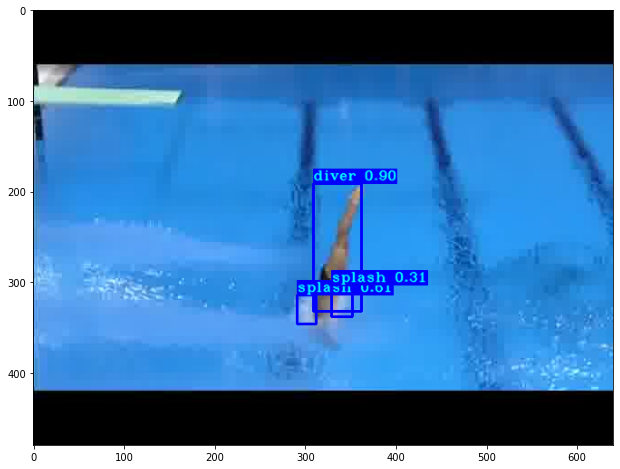

In [17]:
image_path   = "model_training/custom_dataset/train/tigfCJFLZg_00146_0120.jpg"
image = detect_image(yolo, image_path, "", input_size=YOLO_INPUT_SIZE, show=False, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,8))
plt.imshow(image)

## Video Detection

In [2]:
def yolo3_detect_video(video_path:str,output_dir:str,score_threshold:float=0.3)->None:
    """
    Custom function to label videos with our model
    """
    #Setup yolo
    yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES)
    yolo.load_weights("./trained_model/yolov3_custom_v2_half_data")
    
    #Create path:
    timestamp = str(datetime.datetime.now()).replace(":","").replace(" ","_").split(".")[0]
    video_name = os.path.split(video_path)[1].split(".")[0]
    threshold = str(score_threshold)
    output_path = "/".join([output_dir,video_name+"threshold-"+threshold+"_detected_"+timestamp+".mp4"])
    #Detect and save
    detect_video(yolo, video_path=video_path, score_threshold=score_threshold, output_path=output_path, input_size=YOLO_INPUT_SIZE, show=False, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))

In [4]:
video_path="./validation/videos/final_video.mp4" #Video input
output_dir="./validation/video_output"
yolo3_detect_video(video_path,output_dir, 0.9)

Creating yolov3
Time: 1778.32ms, Detection FPS: 0.6, total FPS: 0.6
Time: 1085.43ms, Detection FPS: 0.9, total FPS: 0.9
Time: 864.64ms, Detection FPS: 1.2, total FPS: 1.2
Time: 756.04ms, Detection FPS: 1.3, total FPS: 1.3
Time: 698.32ms, Detection FPS: 1.4, total FPS: 1.4
Time: 663.76ms, Detection FPS: 1.5, total FPS: 1.5
Time: 658.53ms, Detection FPS: 1.5, total FPS: 1.5
Time: 656.49ms, Detection FPS: 1.5, total FPS: 1.5
Time: 641.39ms, Detection FPS: 1.6, total FPS: 1.5
Time: 625.85ms, Detection FPS: 1.6, total FPS: 1.6
Time: 612.16ms, Detection FPS: 1.6, total FPS: 1.6
Time: 602.73ms, Detection FPS: 1.7, total FPS: 1.6
Time: 594.27ms, Detection FPS: 1.7, total FPS: 1.7
Time: 586.99ms, Detection FPS: 1.7, total FPS: 1.7
Time: 585.05ms, Detection FPS: 1.7, total FPS: 1.7
Time: 578.84ms, Detection FPS: 1.7, total FPS: 1.7
Time: 571.29ms, Detection FPS: 1.8, total FPS: 1.7
Time: 564.69ms, Detection FPS: 1.8, total FPS: 1.8
Time: 559.07ms, Detection FPS: 1.8, total FPS: 1.8
Time: 553.03m

# Model Validation

In [ ]:
from model_training.model.yolov3 import Create_Yolo
from model_training.model.utils import detect_image_2
from model_training.model.configs import YOLO_INPUT_SIZE, TRAIN_CLASSES
import statistics
import pandas as pd
from collections import namedtuple
from typing import List
from tabulate import tabulate

#derivated from TRAIN_CLASSES:
CLASS_INDECES = {0:"diver",1:"splash"}
SCORE_THRESHOLD = 0.3
TEST_SIZE = None
"""
FUNCTIONS: 
"""

# Define detections
Detection = namedtuple("Detection", ["image_path", "label", "pred_label", "bbox", "pred_bbox"])

yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES)
yolo.load_weights("./trained_model/yolov3_custom_v2_half_data")

# detect images:
def detections(df: pd.DataFrame, score_threshold=0.3, test_size: int = None) -> List[Detection]:
    """
    Create list of detections for given dataframe.

    Params: score_threshold (min accuracy for bounding box)
            test_size (how many pictures should be tested)
    """
    detections: List[Detection] = []

    if test_size and test_size < len(df):
        df = df.head(test_size)

    for image_path, row in df.iterrows():
        try:
            image, bboxes = detect_image_2(yolo, image_path, "", score_threshold=score_threshold,
                                           input_size=YOLO_INPUT_SIZE, show=False, CLASSES=TRAIN_CLASSES,
                                           rectangle_colors=(255, 0, 0))

            for i in bboxes:
                detections.append(
                    Detection(image_path, row.label, bboxes[-1], (row.startX, row.startY, row.endX, row.endY),
                              tuple(i[:4])))
        except Exception as exc:
            print(f"could not load image: {image_path}", str(exc.__class__.__name__))

    return detections


def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


def get_ious(detections: List[Detection]):
    diverIoU = []
    splashIoU = []
    for detection in detections:
        # compute the intersection over union and display it
        iou = bb_intersection_over_union(detection.bbox, detection.pred_bbox)

        if detection.label == "diver":
            diverIoU.append(iou)
        elif detection.label == "splash":
            splashIoU.append(iou)
    return diverIoU, splashIoU

csv_path = "./validation/afterparty_labels.txt"
# df = pd.read_csv(csv_path,header=None,names=["x_min","y_min","x_max","y_max","class"])
df = pd.read_csv(csv_path,index_col=0)
#create detections

detections = detections(df, SCORE_THRESHOLD, TEST_SIZE)
#get ious for detections

diverIoU,splashIoU = get_ious(detections)
print(diverIoU)

# Display ious

headers=['Label', 'IoU avg', 'IoU min', 'IoU max']
def avg(lst):
    return round(sum(lst) / len(lst), 4)

IoUData = [["diver", avg(diverIoU), round(min(diverIoU), 4), round(max(diverIoU), 4)],
           ["splash", avg(splashIoU), round(min(splashIoU), 4), round(max(splashIoU), 4)]]

print("IoU data for", "yolov3")
print()
print(tabulate(IoUData, headers, tablefmt='orgtbl'))
print()
print("Threshold = ", str(threshold))


# Task 2b

In [6]:
from validation_video import yolo3_detect_video_2a, detect_video
from model_training.model.configs import YOLO_COCO_CLASSES, YOLO_INPUT_SIZE, TRAIN_CLASSES, YOLO_FRAMEWORK

from model_training.model.yolov3 import Create_Yolo

video_path = "./validation/videos/"
output_path = "./validation/video_output/"

video_file_name = "_tigfCJFLZg_00347.mp4"

file_path = video_path + video_file_name
#yolo3_detect_video_2a(video_path = file_path, output_dir = output_path, score_threshold = 0.3)
yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES)
yolo.load_weights("./trained_model/yolov3_custom_v2_half_data")
detect_video(yolo, video_path = file_path, output_path = output_path + video_file_name, score_threshold=0.32, iou_threshold=0.32, CLASSES=TRAIN_CLASSES)

Creating yolov3
Time: 1652.38ms, Detection FPS: 0.6, total FPS: 0.6
Time: 1030.36ms, Detection FPS: 1.0, total FPS: 1.0
Time: 821.10ms, Detection FPS: 1.2, total FPS: 1.2
Time: 715.01ms, Detection FPS: 1.4, total FPS: 1.4
Time: 649.70ms, Detection FPS: 1.5, total FPS: 1.5
Time: 608.11ms, Detection FPS: 1.6, total FPS: 1.6
Time: 587.23ms, Detection FPS: 1.7, total FPS: 1.7
Time: 565.60ms, Detection FPS: 1.8, total FPS: 1.8
Time: 547.77ms, Detection FPS: 1.8, total FPS: 1.8
Time: 533.23ms, Detection FPS: 1.9, total FPS: 1.9
Time: 524.38ms, Detection FPS: 1.9, total FPS: 1.9
Time: 516.00ms, Detection FPS: 1.9, total FPS: 1.9
Time: 524.93ms, Detection FPS: 1.9, total FPS: 1.9
Time: 538.30ms, Detection FPS: 1.9, total FPS: 1.8
Time: 538.86ms, Detection FPS: 1.9, total FPS: 1.8
Time: 537.24ms, Detection FPS: 1.9, total FPS: 1.8
Time: 533.51ms, Detection FPS: 1.9, total FPS: 1.9
Time: 528.27ms, Detection FPS: 1.9, total FPS: 1.9
Time: 522.54ms, Detection FPS: 1.9, total FPS: 1.9
Time: 517.40m